# Introducción

En este trabajo se analizaron **sistemas LTI** (lineales e invariantes en el tiempo) definidos por ecuaciones en diferencias. Se estudió su **respuesta temporal** ante señales de prueba y se **verificó la equivalencia** entre la implementación directa y la **convolución** con la respuesta al impulso.

## Señales de prueba y parámetros

- Senoidal  
- Senoidal desfasada en $\pi/2$  
- Modulada en amplitud (portadora $f$, moduladora $f/2$)  
- Señal recortada al 75 % de su amplitud  
- Cuadrada de $2f$ (en nuestra práctica, $4\,\text{kHz}$)  
- Pulso rectangular de $10\,\text{ms}$

**Parámetros usados:**  
$f = 2\,\text{kHz}$, $f_s = 100\,\text{kHz}$ $\Rightarrow$ $T_s = 1/f_s$.  
En general $N = 500$ muestras $\Rightarrow$ $T_{\text{sim}} = N\,T_s = 5\,\text{ms}$.  
Para el **pulso** se usó $N_{\text{pulso}} = 2000$ ($20\,\text{ms}$) para observar mejor el transitorio.  
Todas las señales se trataron como **causales** con **condiciones iniciales nulas**.

## Métodos de resolución

- **Ejercicio 1 (manual):** implementación directa de la ecuación en diferencias $y[n]$ con bucle y condicionales (causalidad).  
- **Ejercicio 2 (automático):** `scipy.signal.lfilter(b, a, x)` con los coeficientes del numerador/denominador de $H(z)$.


In [1]:
"""
Created on Fri Sep  5 22:46:57 2025

@author: joacomillo12
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

from scipy import signal

#Aca uso todo lo mismo que en la ts1. Tambien podria importar el archivo pero se le va a complicar a los profes.
fs = 100000
N = 1000
f = 2000
Ts = 1/fs
tt = np.arange(N) * Ts           # vector de tiempo

deltaF = fs/N
def mi_funcion_sen(vmax, dc, f, fase, N, fs):
    Ts = 1/fs
    tt = np.arange(N) * Ts           # vector de tiempo
    xx = dc + vmax * np.sin(2* np.pi * f * tt + fase)  # señal senoidal
    return tt, xx

#Para hacer modulacion hay que multplicar una señal contra otra señal.
def modulacion(vmax, dc, f, fase, N, fs):
    tt, xx = mi_funcion_sen(vmax=1, dc=0, f=f, fase=0, N = N, fs=fs)
    tt, x1 = mi_funcion_sen(vmax=1, dc=0, f=f/2, fase=0, N = N, fs=fs)
    x2 = xx * x1
    return x2


tt, xx = mi_funcion_sen(vmax=1, dc=0, f=f, fase=0, N = N, fs=fs)
tt, x1 = mi_funcion_sen(vmax=1, dc=0, f=f, fase=np.pi/2, N = N, fs=fs)
x2 = modulacion(vmax=1, dc=0, f=f, fase=0, N = N, fs=fs)

#Forma de hacer el clipeo para recortar la amplitud de la señal. 
x3 = np.clip(xx,-0.75,0.75,out=None)

x4 = signal.square(2*np.pi*4000*tt)
x4 = x4 - np.mean(x4)
#este print esta para ver si le saque a la cuadrada la media. remoción de DC
#print("mean x4:", np.mean(x4))      # ~ 0.0
#print("sum x4:", np.sum(x4))        # ~ 0

# aca hago el del puslo. Como Npulso = Tpulso . fs. Voy a tener 200 muestras
# como mi N lo tengo fijo en 500. voy a tener 300 muestras que estan en 0. Si yo aumento N por ejemplo, siempre voy a tener fijas 200muestras que valen 1 y las N-200=0.
#Si yo cambio fs, me cambia el Npulso entonces ahi ya se modifican las muestras que valen 1. 
T_pulso = 0.01    # 10 ms 
N_pulso = int(T_pulso * fs)  # 500 muestras

N1 = 2000   # señal total de 40 ms
pulso = np.zeros(N1)
pulso[:N_pulso] = 1
tt_pulso = np.arange(N1) * Ts   # vector de tiempo consistente con N

potencia_xx = np.mean(xx**2)
potencia_x1 = np.mean(x1**2)
potencia_x2 = np.mean(x2**2)
potencia_x3 = np.mean(x3**2)
potencia_x4 = np.mean(x4**2)
energia_pulso = np.sum(pulso**2) * Ts #aca uso energia porque, Señales no periódicas o de duración finita. energía en unidades tiempo·amplitud^2
print("Señal principal, Ts: ",Ts, " N: ", N, "y potencia promedio:", potencia_xx)
print("Señal desfada, Ts: ",Ts, " N: ", N, "y potencia promedio:", potencia_x1)
print("Señal modulada, Ts: ",Ts, " N: ", N, "y potencia promedio:", potencia_x2)
print("Señal recortada, Ts: ",Ts, " N: ", N, "y potencia promedio:", potencia_x3)
print("Señal cuadrada, Ts: ",Ts, " N: ", N, "y potencia promedio:", potencia_x4)
print("Señal pulso, Ts: ",Ts, " N: ", N, "y energia:", energia_pulso)
print("\n")

Señal principal, Ts:  1e-05  N:  1000 y potencia promedio: 0.5
Señal desfada, Ts:  1e-05  N:  1000 y potencia promedio: 0.5
Señal modulada, Ts:  1e-05  N:  1000 y potencia promedio: 0.25000000000000006
Señal recortada, Ts:  1e-05  N:  1000 y potencia promedio: 0.3707402889009137
Señal cuadrada, Ts:  1e-05  N:  1000 y potencia promedio: 0.9987039999999999
Señal pulso, Ts:  1e-05  N:  1000 y energia: 0.01




## Tratamiento de la cuadrada

Para evitar la deriva por DC residual en la cuadrada, se **removió la media**:

$x_4 \leftarrow x_4 - \overline{x_4},\qquad
\overline{x_4}=\frac{1}{N}\sum_{n=0}^{N-1}x_4[n],$

asegurando $\overline{x_4}\approx 0$ y $\sum_n x_4[n]\approx 0$.  
Así, la salida refleja la **integración periódica** (forma tipo triangular) **sin rampa**.

## Modelo del sistema (Ejercicio 1)

Ecuación en diferencias:
$y[n]=0.03\,x[n]+0.05\,x[n-1]+0.03\,x[n-2]+1.5\,y[n-1]-0.5\,y[n-2]$

Función de transferencia:

$H(z)=\frac{0.03+0.05\,z^{-1}+0.03\,z^{-2}}{1-1.5\,z^{-1}+0.5\,z^{-2}}$

Polos:
$z \in \{1,\;0.5\}$

- El **polo en $z=1$** implica **ganancia infinita en DC** (integrador): cualquier componente en DC de la entrada produce **deriva** (rampa) en la salida.  
- El **polo en $z=0.5$** (dentro del círculo unidad) introduce un **transitorio amortiguado** (*ringing*) tras cambios bruscos.

## Verificación por convolución

Se obtuvo la respuesta al impulso $h[n]$ excitando con $\delta[n]$ y se verificó:

$y[n] \equiv (x*h)[n].$

En el código se mantuvo **causalidad** y **longitud** usando:

$y_{\text{conv}}=\texttt{np.convolve}(x,\;h)\,[0{:}\,\texttt{len}(x)]$

Al usar la convolución con una respuesta al impulso truncada (h[n] finita), se observan discrepancias al inicio y al final de la señal. Esto se debe a los efectos de borde, causados por la suposición de condiciones iniciales nulas y por el hecho de que, en las primeras y últimas muestras, la ventana de convolución no está completamente solapada con la entrada.

## Métricas reportadas

- **Potencia** (señales periódicas): $\displaystyle P=\frac{1}{N}\sum_{n=0}^{N-1} y^2[n]$.  
- **Energía** (pulso): $\displaystyle E=\sum_{n} y^2[n]$.
"""))

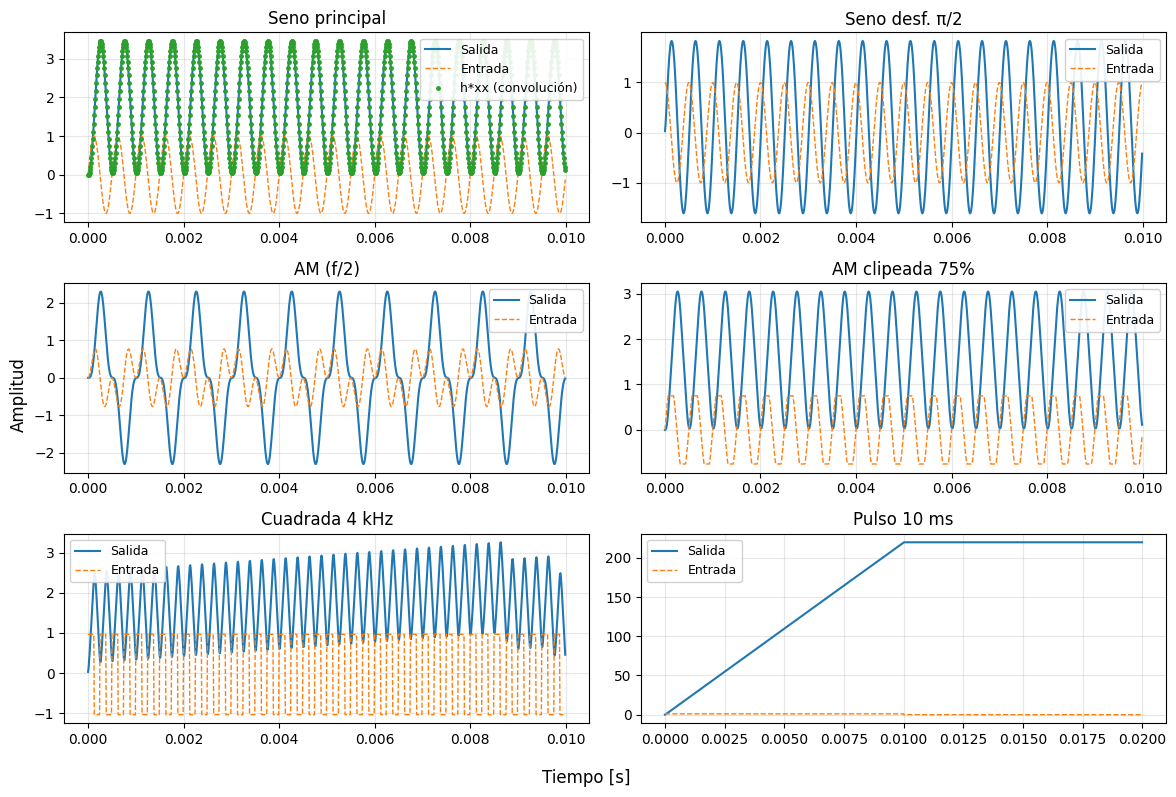

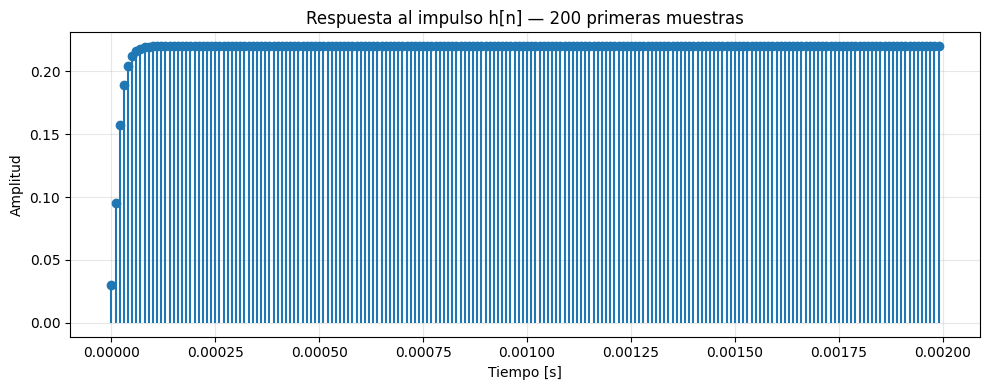

In [2]:

def en_diferencias(N,x):
    y = np.zeros(N)
    for n in range (N):
        x0 = x[n]
        x1 = x[n-1] if n-1 >= 0 else 0
        x2 = x[n-2] if n-2 >= 0 else 0
        y1 = y[n-1] if n-1 >= 0 else 0
        y2 = y[n-2] if n-2 >= 0 else 0
        y[n] = 3* 10**(-2)*x0 + 5 * 10**(-2)*x1 +  3 * 10**(-2)*x2 + 1.5*y1-0.5*y2
    return y

entradas = [
    (xx,   "Seno principal"),
    (x1,   "Seno desf. π/2"),
    (x2,   "AM (f/2)"),
    (x3,   "AM clipeada 75%"),
    (x4,   "Cuadrada 4 kHz"),
    (pulso,"Pulso 10 ms"),
]

# convolucion de la entrada xx con delta
delta = np.zeros(len(xx))
delta[0] = 1
h = en_diferencias(N = N, x = delta)
y_conv = np.convolve(xx, h)[:N]

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs = axs.ravel()  # aplanar para poder usar axs[i]

for i, (x, nombre) in enumerate(entradas):
    y = en_diferencias(len(x), x)
    t = np.arange(len(x)) * Ts

    ax = axs[i]
    ax.plot(t, y, label="Salida", linewidth=1.5)
    ax.plot(t, x, '--', label="Entrada", linewidth=1.0)
    if i == 0:  # primer subplot corresponde a xx
        ax.plot(t, y_conv, linestyle='none', marker='o', markersize=2.5,label="h*xx (convolución)")

    ax.set_title(nombre)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, framealpha=0.9)

fig.supxlabel("Tiempo [s]")
fig.supylabel("Amplitud")
fig.tight_layout()
plt.show()


t_h = np.arange(len(h)) * Ts

plt.figure(figsize=(10,4))
plt.stem(t_h[:200], h[:200], basefmt=" ")
plt.title("Respuesta al impulso h[n] — 200 primeras muestras")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()



# Parte 2 — Sistemas en diferencias: FIR vs IIR (h[n], salida senoidal y verificación)

En esta parte se analizan dos sistemas LTI definidos por ecuaciones en diferencias y se estudia su **respuesta al impulso** $h[n]$, la **salida ante una senoidal** y la **verificación** entre implementación con `lfilter` y convolución causal.

## Planteo de los sistemas

1. **FIR (no recursivo)**
$$
y[n] \;=\; x[n] \;+\; 3\,x[n-10]
$$

2. **IIR (recursivo)**
$$
y[n] \;=\; x[n] \;+\; 3\,y[n-10]
$$

## Qué esperar en los gráficos

- **Para $y[n]=x[n]+3\,x[n-10]$ (sin realimentación):**  
  Coincidencia casi exacta entre la salida calculada con `lfilter` y la obtenida por **convolución causal** con $h[n]$.  
  Si la entrada es senoidal, la salida mantiene la **misma frecuencia** y se observa un **cambio de amplitud** y un **desplazamiento de fase** que dependen de la frecuencia.  
  Las únicas diferencias visibles suelen estar en las **primeras/últimas muestras** por efectos de borde.

- **Para $y[n]=x[n]+3\,y[n-10]$ (con realimentación a 10 muestras):**  
  Como cada valor de salida usa también el valor de salida de **hace 10 muestras** multiplicado por 3, la amplitud **tiende a crecer** con el tiempo.  
  Aun así, la implementación con `lfilter` y la **convolución causal** con $h[n]$ (truncada) **coinciden** en el tramo simulado.  

## Metodología y verificación en el notebook

- **Implementación con `lfilter`:**  
  FIR: $b=[1,0,\dots,0,3]$ (retardo 10), $a=[1]$.  
  IIR: $b=[1]$, $a=[1,0,\dots,0,-3]$ (con $a_{10}=-3$).

- **Respuesta al impulso** (truncada a $N$ muestras): excitar con $\delta[n]$ (vector con 1 en $n=0$ y ceros en el resto) y filtrar.

- **Convolución causal** y alineada para comparar con `lfilter`/diferencias:
$$
y_{\text{conv}} \;=\; \mathrm{np.convolve}(x,\;h,\;\text{"full"})\,[\,:\mathrm{len}(x)\,].
$$




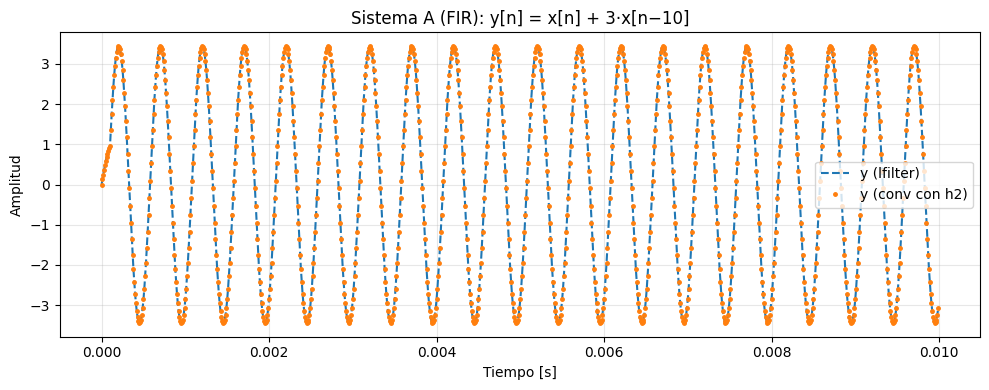

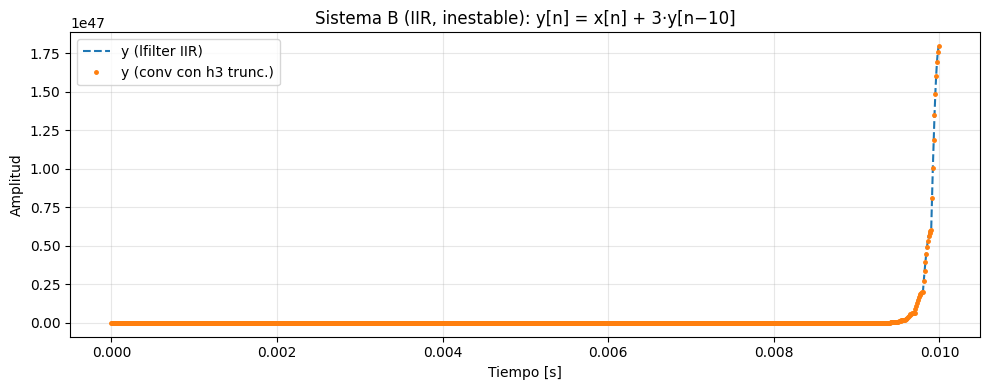

In [3]:
b2 = np.zeros(11)
b2[0] = 1.0
b2[10] = 3.0
a2 = np.array([1.0])
y2  = lfilter(b2, a2, xx)

delta = np.zeros(len(xx))
delta[0] = 1
h2  = lfilter(b2, a2, delta)               
y2_conv = np.convolve(xx, h2, mode='full')[:N]  # causal
#y2_conv = y2_conv1[:len(xx)]  


plt.figure(figsize=(10,4))
plt.plot(tt, y2, '--', label="y (lfilter)", linewidth=1.5)
plt.plot(tt, y2_conv, linestyle='none', marker='o', markersize=2.5, label="y (conv con h2)")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud")
plt.title("Sistema A (FIR): y[n] = x[n] + 3·x[n−10]")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()

# Sistema B (IIR): y[n] = x[n] + 3 y[n-10]  (INESTABLE)

b3 = np.array([1.0])
a3 = np.zeros(11)
a3[0]  = 1.0   # y[n]
a3[10] = -3.0  # -3 y[n-10]
y3  = lfilter(b3, a3, xx)

h3 = lfilter(b3, a3, delta)     # [1, 0.., 3, 0.., 9, ...] hasta len(xx)

y3_conv = np.convolve(xx, h3, mode='full')[:N]    # mismo largo que xx

# --- Plot comparación --------------------------------------------------------

plt.figure(figsize=(10,4))
plt.plot(tt, y3, '--', label="y (lfilter IIR)", linewidth=1.5)
plt.plot(tt, y3_conv, linestyle='none', marker='o', markersize=2.5, label="y (conv con h3 trunc.)")
plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud")
plt.title("Sistema B (IIR, inestable): y[n] = x[n] + 3·y[n−10]")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.show()


# Conclusion 
En este trabajo aprendí a utilizar ecuaciones en diferencias implementando manualmente la sumatoria discreta de $y[n]$. Esto me devolvía una salida en función de una entrada y de los coeficientes que definían el sistema. Luego pude usar la convolución para comprobar que, efectivamente, si se convoluciona la entrada con la respuesta al impulso, se obtiene la misma salida que antes. Se analizó en detalle cómo se comportan los sistemas LTI frente a las señales utilizadas en la TS1.

En este informe tuve que incorporar algo más de teoría para comprender mejor el comportamiento de sistemas y señales. Lo de los polos lo habíamos visto en Cálculo 3, pero no aplicado al contexto de señales, y resultó ser un factor muy importante para entender por qué mis salidas no se veían como esperaba. Buscando información en internet y con la ayuda de ChatGPT, pude entender mejor la base de todo esto. Hay algunos conceptos que todavía no termino de comprender al 100%, como por ejemplo por qué aparecía una “rampa” en la salida de la cuadrada, pero comparando con cuando empecé la TS2, ahora puedo aproximarme a justificarlo, como expliqué en el informe.

Desde el punto de vista práctico, el trabajo no fue complejo, ya que los códigos se explicaron en clase y gracias a lfilter las simulaciones se simplificaron bastante. Sin embargo, desde el lado teórico hay muchos conceptos que aún no vimos en profundidad como para analizarlos completamente por nuestros propios medios. Haciendo bastante trabajo en casa pude llegar a este informe, que cumple con mis expectativas y me deja varios conceptos importantes que aprendí en el proceso.



**Qué me llevo:**  
- Cómo pasar de una ecuación en diferencias a su $h[n]$ por excitación con $delta[n]$ y usarla para validar salidas por **convolución causal**.  
- La importancia de chequear **media** y **alineación temporal** en las señales de prueba.

Indicar una opción:

Resolví la tarea, pero tengo dudas. Como dije antes, los conceptos teoricos son mas dificiles de abordar pero hay que seguir aprendiendo. 

¿Qué aprendiste al hacer esta tarea?
¿Qué te quedó claro? ¿Qué te sigue costando?
Ya lo conteste en la conclusión 

Indicar si se utilizó IA:

Sí, usé chatGPT, Qwen, Deepseek, Gemini, otra.

Escritura
Conceptos teorícos
Gráficos


